# Exemplo de Tensorflow
## Detecção de anomalias
Este notebook foi baseado neste [artigo](https://www.tensorflow.org/tutorials/generative/autoencoder?hl=pt-br).

Neste exemplo, você treinará um autoencoder para detectar anomalias no [conjunto de dados ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Este conjunto de dados contém 5.000 eletrocardiogramas , cada um com 140 pontos de dados. Você usará uma versão simplificada do conjunto de dados, onde cada exemplo foi rotulado como 0 (correspondente a um ritmo anormal) ou 1 (correspondente a um ritmo normal). Você está interessado em identificar os ritmos anormais.
> **Observação:** este é um conjunto de dados rotulado, portanto, você pode expressar isso como um problema de aprendizado supervisionado. O objetivo deste exemplo é ilustrar os conceitos de detecção de anomalias que você pode aplicar a conjuntos de dados maiores, nos quais não há rótulos disponíveis (por exemplo, se você tiver muitos milhares de ritmos normais e apenas um pequeno número de ritmos anormais).

Como você detectará anomalias usando um autoencoder? Lembre-se de que um autoencoder é treinado para minimizar o erro de reconstrução. Você treinará um autoencoder apenas nos ritmos normais, depois o usará para reconstruir todos os dados. Nossa hipótese é que os ritmos anormais terão maior erro de reconstrução. Você então classificará um ritmo como uma anomalia se o erro de reconstrução ultrapassar um limite fixo.

### Importar Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

### Carregar dados de ECG
O conjunto de dados que você usará é baseado em um de [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize os dados para [0,1].

In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Você treinará o autoencoder usando apenas os ritmos normais, que são rotulados neste conjunto de dados como 1 . Separe os ritmos normais dos ritmos anormais.

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plote um ECG normal.

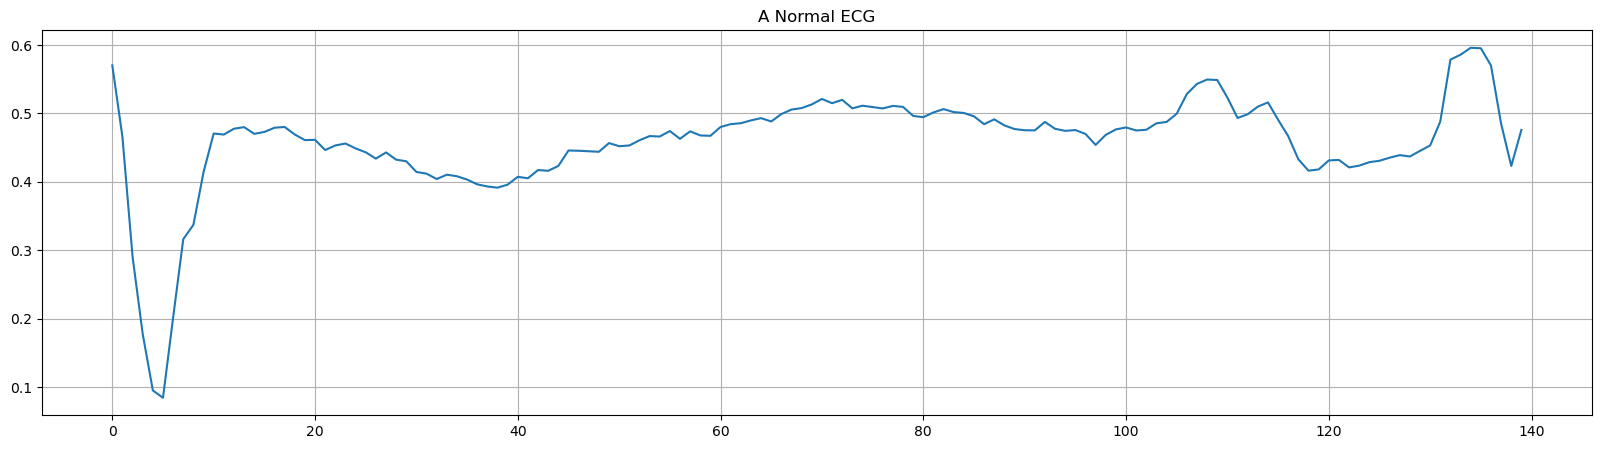

In [6]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plote um ECG anômalo.

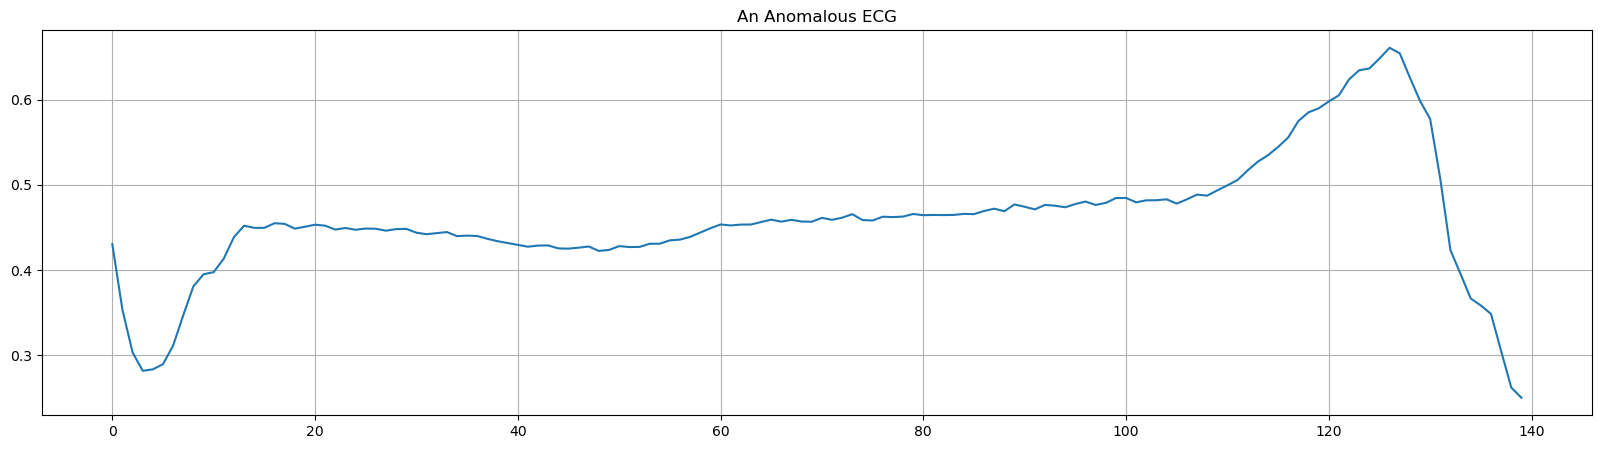

In [7]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

Construir o modelo

In [8]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')

Observe que o autoencoder é treinado usando apenas os ECGs normais, mas é avaliado usando o conjunto de teste completo.

In [10]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0583 - val_loss: 0.0535
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0566 - val_loss: 0.0520
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0538 - val_loss: 0.0500
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0496 - val_loss: 0.0479
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0444 - val_loss: 0.0458
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0395 - val_loss: 0.0428
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0355 - val_loss: 0.0415
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0322 - val_loss: 0.0398
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0294 - val_loss: 0.0389
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0274 - val_loss: 0.0380
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0262 - val_loss: 0.0370
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0253 - val_loss: 0.0364
Epoch 13/2

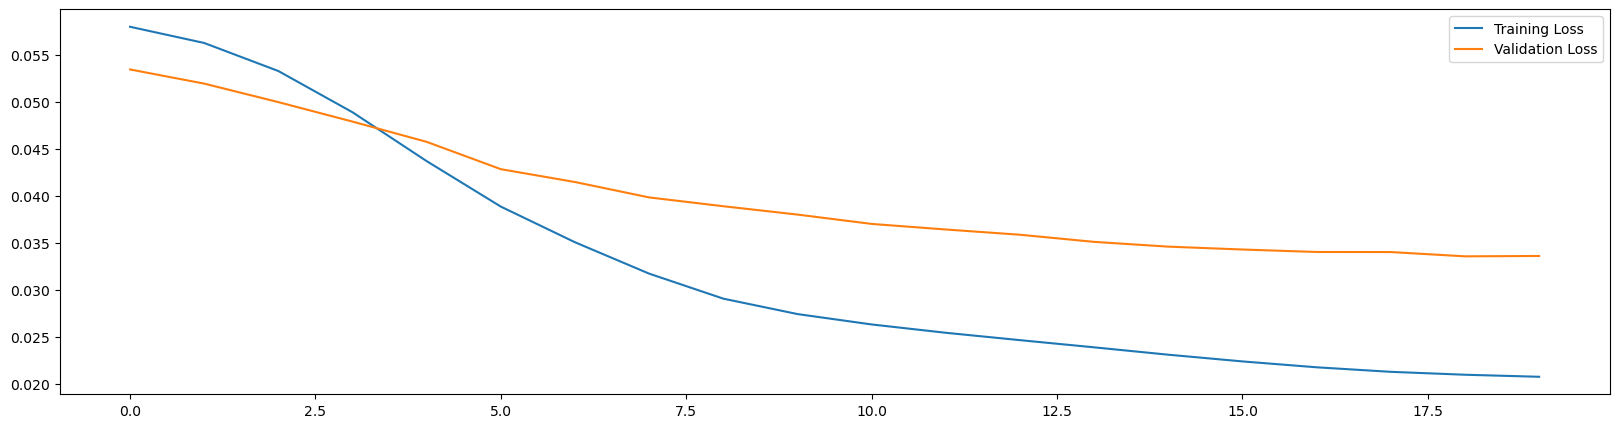

In [11]:
plt.figure(figsize=(20,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
_ = plt.legend()

Você logo classificará um ECG como anômalo se o erro de reconstrução for maior que um desvio padrão dos exemplos normais de treinamento. Primeiro, vamos plotar um ECG normal do conjunto de treinamento, a reconstrução depois de codificado e decodificado pelo autoencoder e o erro de reconstrução.

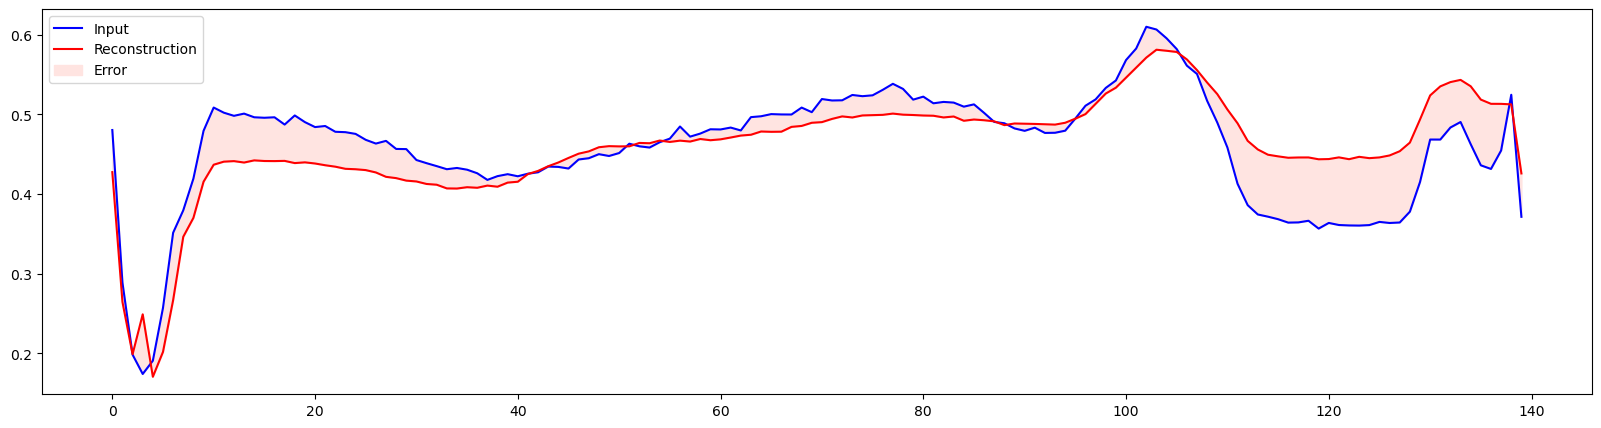

In [12]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(20,5))
plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='mistyrose')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Crie um gráfico semelhante, desta vez para um exemplo de teste anômalo.

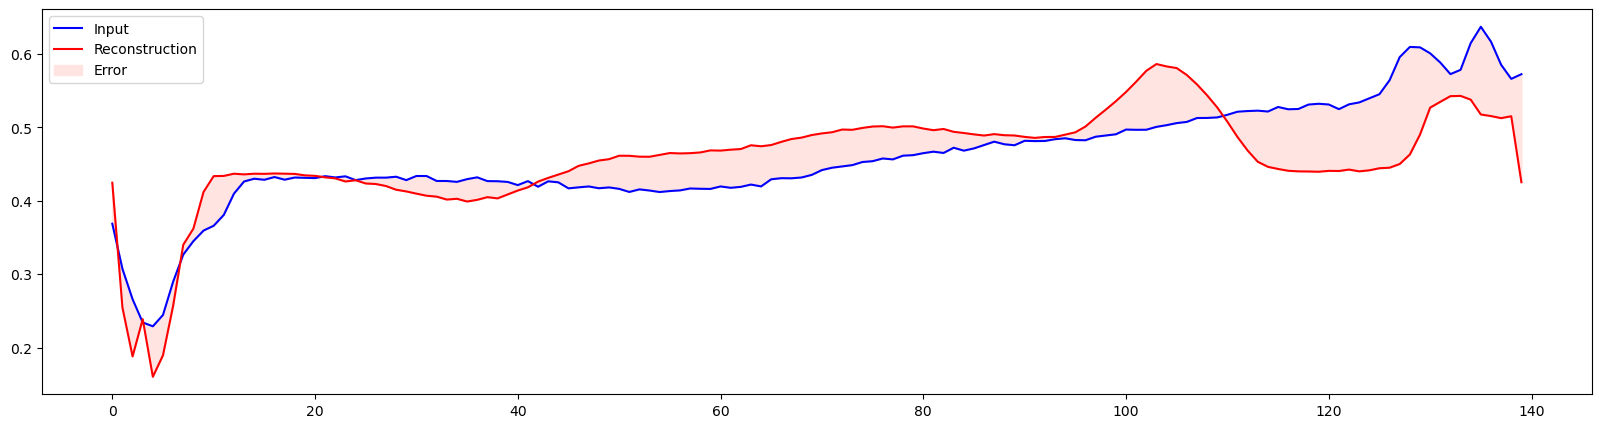

In [13]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(20,5))
plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='mistyrose')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detectar anomalias
Detecte anomalias calculando se a perda de reconstrução é maior que um limite fixo. Neste tutorial, você calculará o erro médio médio para exemplos normais do conjunto de treinamento e, em seguida, classificará os exemplos futuros como anômalos se o erro de reconstrução for maior que um desvio padrão do conjunto de treinamento.

Plote o erro de reconstrução em ECGs normais do conjunto de treinamento

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


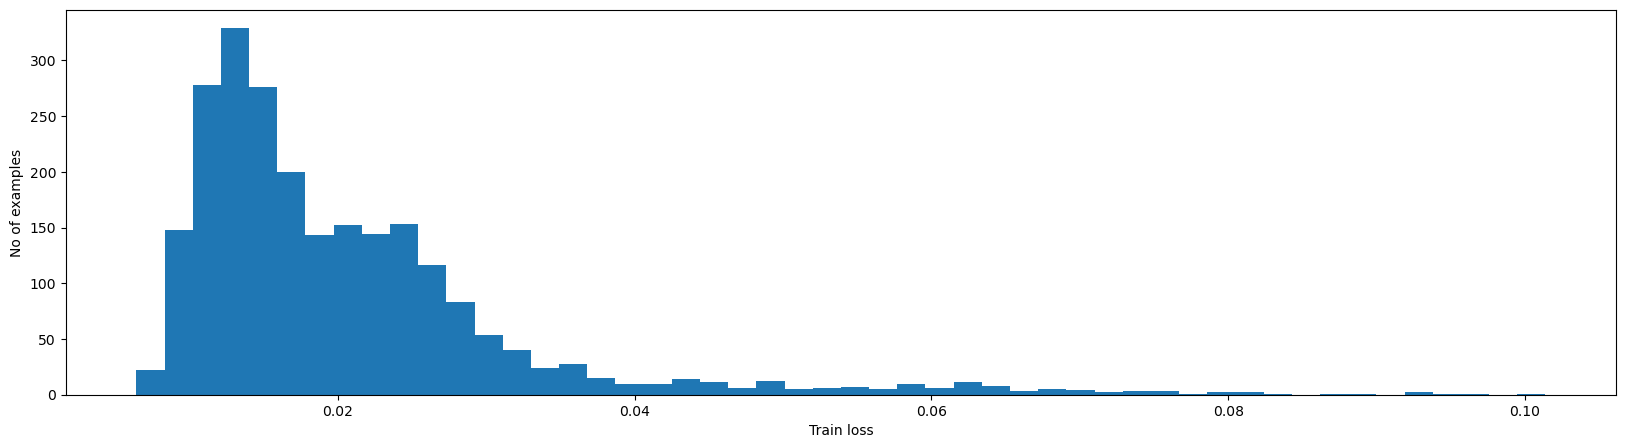

In [14]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.figure(figsize=(20,5))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

## Escolha um valor limite que seja um desvio padrão acima da média.

In [16]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032681927


> **Observação:** existem outras estratégias que você pode usar para selecionar um valor limite acima do qual os exemplos de teste devem ser classificados como anômalos. A abordagem correta dependerá do seu conjunto de dados. Você pode aprender mais com os links no final deste tutorial.

Se você examinar o erro de reconstrução dos exemplos anômalos no conjunto de teste, notará que a maioria tem um erro de reconstrução maior do que o limite. Variando o limite, você pode ajustar a precisão e a recuperação do seu classificador.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


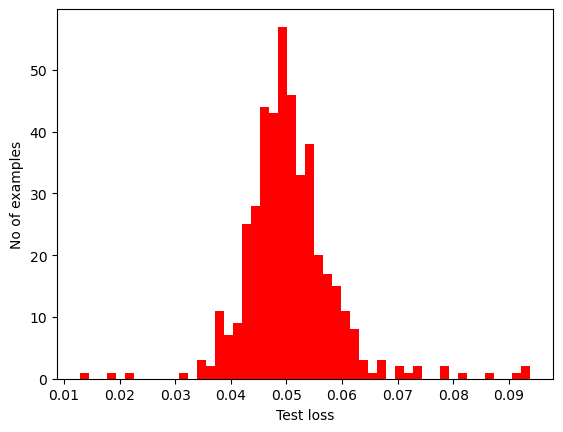

In [17]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50, color='red')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

## Avaliação do Modelo
Classifique um ECG como uma anomalia se o erro de reconstrução for maior que o limite. As métricas utilizadas estão explicadas abaixo e neste [link](https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall#:~:text=Accuracy%20shows%20how%20often%20a,when%20predicting%20the%20target%20class.) pode encontrar maiores detalhes.
- __Accuracy__ shows how often a classification ML model is correct overall.
- __Precision__ shows how often an ML model is correct when predicting the target class.
- __Recall__ shows whether an ML model can find all objects of the target class. 

In [18]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [19]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


### Próximos passos
Para saber mais sobre detecção de anomalias com autoencoders, confira este excelente [exemplo interativo](https://anomagram.fastforwardlabs.com/#/)
criado com TensorFlow.js por Victor Dibia. Para um caso de uso do mundo real, você pode aprender como o [Airbus detecta anomalias nos dados de telemetria da ISS](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html?hl=pt-br&_gl=1*1n7jy5g*_ga*MTY0MzU0MTYwMC4xNjk0NzI5NTQy*_ga_W0YLR4190T*MTY5NDc0MDk4My4yLjEuMTY5NDc0MTU5NS4wLjAuMA..) usando o TensorFlow. Para saber mais sobre o básico, considere ler esta [postagem no blog](https://blog.keras.io/building-autoencoders-in-keras.html) de François Chollet. Para mais detalhes, confira o capítulo 14 do [Deep Learning](https://www.deeplearningbook.org/) de Ian Goodfellow, Yoshua Bengio e Aaron Courville.